In [2]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely.geometry
import shapely
import rasterio
import rioxarray
from rasterio.features import shapes
from shapely.geometry import shape
import matplotlib.pyplot as plt
from pathlib import Path

from shapely import affinity
from shapely.geometry.multipolygon import MultiPolygon
from scipy.spatial import Voronoi

In [6]:
lccs_resolution = 300 #m
areapergrid = (lccs_resolution/1000) ** 2 ## km2

weight_wind = [
    0.0632, #landuse
    0.0502, #slope
    0.0942, #elevation
    0.0772, #d to settlement
    0.0192, #d to wetland
    0.0302, #d to forest
    0.0502, #prox to road
    0.0942, #prox to sub
    0.2672, #Resource quality
    0.2532 #Farm Required area
    ]
print('weight_wind = ',sum(weight_wind))

weight_solar = [
    0.1433, #landuse
    0.1293, #slope
    0.0663, #elevation
    0.0603, #d to settlement
    0.0363, #d to wetland
    0.0143, #d to forest
    0.0503, #prox to road
    0.1023, #prox to sub
    0.2573, #Resource quality
    0.1383 #Farm Required area
    ]
print('weight_solar = ' , sum(weight_solar))


weight_biomass = [
    0.2650, #landuse
    0.1030, #slope
    0.0730, #elevation
    0.1820, #d to settlement
    0.1440, #d to wetland
    0.000,  #d to forest
    0.0700, #prox to road
    0.0560, #prox to sub
    0.000, #Resource quality
    0.1070 #Area feedstock
    ]
print('weight_biomass = ',sum(weight_biomass))

weight_bgec = [
    0.2650, #landuse
    0.1030, #slope
    0.0730, #elevation
    0.1820, #d to settlement
    0.1440, #d to wetland
    0.000,  #d to forest
    0.0700, #prox to road
    0.0560, #prox to sub
    0.000, #Resource quality
    0.1070 #Area feedstock
    ]
print('weight_bgec = ',sum(weight_bgec))

weight_bgww = [
    0.2650, #landuse
    0.1030, #slope
    0.0730, #elevation
    0.1820, #d to settlement
    0.1440, #d to wetland
    0.000,  #d to forest
    0.0700, #prox to road
    0.0560, #prox to sub
    0.000, #Resource quality
    0.1070 #Area feedstock
    ]
print('weight_bgww = ',sum(weight_bgww))

weight_msw = [
    0.2650, #landuse
    0.1030, #slope
    0.0730, #elevation
    0.1820, #d to settlement
    0.1440, #d to wetland
    0.000,  #d to forest
    0.0700, #prox to road
    0.0560, #prox to sub
    0.000, #Resource quality
    0.1070 #Area feedstock
    ]
print('weight_msw = ',sum(weight_msw))

weight_iew = [
    0.2650, #landuse
    0.1030, #slope
    0.0730, #elevation
    0.1820, #d to settlement
    0.1440, #d to wetland
    0.000,  #d to forest
    0.0700, #prox to road
    0.0560, #prox to sub
    0.000, #Resource quality
    0.1070 #Area feedstock
    ]
print('weight_iew = ',sum(weight_iew))

print('areapergrid = ',areapergrid)

weight_wind =  0.999
weight_solar =  0.998
weight_biomass =  1.0
weight_bgec =  1.0
weight_bgww =  1.0
weight_msw =  1.0
weight_iew =  1.0
areapergrid =  0.09


In [3]:
## Create teh final SI map template ###
xr_final_SI = xr.open_dataset('Output\\xr_SI_Landcover.nc')
# xr_final_SI = xr_final_SI.drop_vars('lccs_class')
# xr_final_SI = xr_final_SI.drop_vars('SI_BGEC')
# xr_final_SI = xr_final_SI.drop_vars('SI_Biomass')
# xr_final_SI = xr_final_SI.drop_vars('SI_BGWW')
# xr_final_SI = xr_final_SI.drop_vars('SI_MSW')
# xr_final_SI = xr_final_SI.drop_vars('SI_IEW')

xr_final_SI['AVA_Wind'] = xr_final_SI['SI_Wind']
xr_final_SI['AVA_Solar'] = xr_final_SI['SI_Solar']
xr_final_SI['AVA_Biomass'] = xr_final_SI['SI_Biomass']
xr_final_SI['AVA_BGEC'] = xr_final_SI['SI_BGEC']
xr_final_SI['AVA_BGWW'] = xr_final_SI['SI_BGWW']
xr_final_SI['AVA_MSW'] = xr_final_SI['SI_MSW']
xr_final_SI['AVA_IEW'] = xr_final_SI['SI_IEW']

xr_final_SI['SI_Wind'] = 0.0
xr_final_SI['SI_Solar'] = 0.0
xr_final_SI['SI_Biomass'] = 0.0
xr_final_SI['SI_BGEC'] = 0.0
xr_final_SI['SI_BGWW'] = 0.0
xr_final_SI['SI_MSW'] = 0.0
xr_final_SI['SI_IEW'] = 0.0

xr_final_SI['AVA_Wind'] = 0
xr_final_SI['AVA_Solar'] = 0
xr_final_SI['AVA_Biomass'] = 0
xr_final_SI['AVA_BGEC'] = 0
xr_final_SI['AVA_BGWW'] = 0
xr_final_SI['AVA_MSW'] = 0
xr_final_SI['AVA_IEW'] = 0

print(xr_final_SI)
check_weight_wind = 0
check_weight_solar = 0
check_weight_biomass = 0
check_weight_bgec = 0
check_weight_bgww = 0
check_weight_msw = 0
check_weight_iew = 0


<xarray.Dataset>
Dimensions:      (lat: 5346, lon: 2985)
Coordinates:
  * lat          (lat) float64 5.615 5.618 5.621 5.624 ... 20.46 20.46 20.46
  * lon          (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables: (12/21)
    lccs_class   (lat, lon) int64 ...
    SI_BGEC      float64 0.0
    SI_Biomass   float64 0.0
    SI_Solar     float64 0.0
    SI_Wind      float64 0.0
    SI_BGWW      float64 0.0
    ...           ...
    AVA_Solar    int32 0
    AVA_Biomass  int32 0
    AVA_BGEC     int32 0
    AVA_BGWW     int32 0
    AVA_MSW      int32 0
    AVA_IEW      int32 0


<xarray.Dataset>
Dimensions:      (lat: 5346, lon: 2985)
Coordinates:
  * lat          (lat) float64 5.615 5.618 5.621 5.624 ... 20.46 20.46 20.46
  * lon          (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables: (12/21)
    lccs_class   (lat, lon) int64 ...
    SI_BGEC      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Biomass   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_BGWW      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...           ...
    AVA_Solar    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Biomass  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_BGEC     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_BGWW     (lat, lon) float64 0.0 0.0 0.0 0.0 

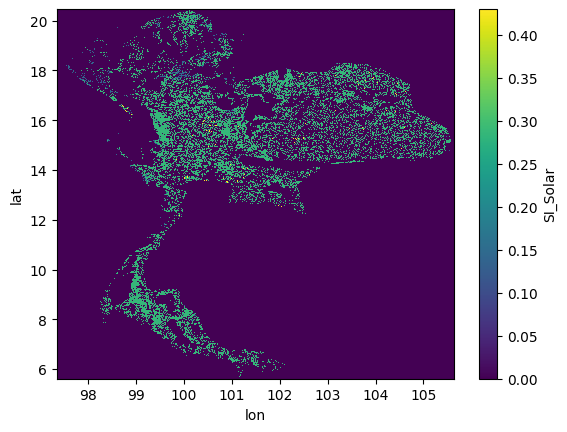

In [4]:
xr_landuse_suitability_index = xr.open_dataset('Output\\xr_SI_Landcover.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_landuse_suitability_index['SI_Wind'] * weight_wind[0])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_landuse_suitability_index['SI_Solar'] * weight_solar[0])
xr_final_SI['SI_Biomass'] = xr_final_SI['SI_Biomass'] + (xr_landuse_suitability_index['SI_Biomass'] * weight_biomass[0])
xr_final_SI['SI_BGEC'] = xr_final_SI['SI_BGEC'] + (xr_landuse_suitability_index['SI_BGEC'] * weight_bgec[0])
xr_final_SI['SI_BGWW'] = xr_final_SI['SI_BGWW'] + (xr_landuse_suitability_index['SI_BGWW'] * weight_bgww[0])
xr_final_SI['SI_MSW'] = xr_final_SI['SI_MSW'] + (xr_landuse_suitability_index['SI_MSW'] * weight_msw[0])
xr_final_SI['SI_IEW'] = xr_final_SI['SI_IEW'] + (xr_landuse_suitability_index['SI_IEW'] * weight_iew[0])

xr_final_SI['AVA_Wind'] = xr.where(xr_landuse_suitability_index['SI_Wind'] > 0 ,0.09,0)
xr_final_SI['AVA_Solar'] = xr.where(xr_landuse_suitability_index['SI_Solar'] > 0 ,0.09,0)
xr_final_SI['AVA_Biomass'] = xr.where(xr_landuse_suitability_index['SI_Biomass'] > 0 ,0.09,0)
xr_final_SI['AVA_BGEC'] = xr.where(xr_landuse_suitability_index['SI_BGEC'] > 0 ,0.09,0)
xr_final_SI['AVA_BGWW'] = xr.where(xr_landuse_suitability_index['SI_BGWW'] > 0 ,0.09,0)
xr_final_SI['AVA_MSW'] = xr.where(xr_landuse_suitability_index['SI_MSW'] > 0 ,0.09,0)
xr_final_SI['AVA_IEW'] = xr.where(xr_landuse_suitability_index['SI_IEW'] > 0 ,0.09,0)

print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[0]
check_weight_solar = check_weight_solar + weight_solar[0]
check_weight_biomass = check_weight_biomass + weight_biomass[0]
check_weight_bgec = check_weight_bgec + weight_bgec[0]
check_weight_bgww = check_weight_bgww + weight_bgww[0]
check_weight_msw = check_weight_msw + weight_msw[0]
check_weight_iew = check_weight_iew + weight_iew[0]

print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("check_weight_biomass = ",check_weight_biomass)
print("check_weight_bgec = ",check_weight_bgec)
print("check_weight_bgww = ",check_weight_bgww)
print("check_weight_msw = ",check_weight_msw)
print("check_weight_iew = ",check_weight_iew)

print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())
print("AVA Biomass = ",xr_final_SI['AVA_Biomass'].sum())
print("AVA BGEC = ",xr_final_SI['AVA_BGEC'].sum())
print("AVA BGWW = ",xr_final_SI['AVA_BGWW'].sum())
print("AVA MSW = ",xr_final_SI['AVA_MSW'].sum())
print("AVA IEW = ",xr_final_SI['AVA_IEW'].sum())

xr_final_SI['SI_Solar'].plot()

In [5]:
xr_cal = xr.open_dataset('Output\\xr_SI_Slope.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[1])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[1])
xr_final_SI['SI_Biomass'] = xr_final_SI['SI_Biomass'] + (xr_cal['SI_Biomass'] * weight_biomass[1])
xr_final_SI['SI_BGEC'] = xr_final_SI['SI_BGEC'] + (xr_cal['SI_BGEC'] * weight_bgec[1])
xr_final_SI['SI_BGWW'] = xr_final_SI['SI_BGWW'] + (xr_cal['SI_BGWW'] * weight_bgww[1])
xr_final_SI['SI_MSW'] = xr_final_SI['SI_MSW'] + (xr_cal['SI_MSW'] * weight_msw[1])
xr_final_SI['SI_IEW'] = xr_final_SI['SI_IEW'] + (xr_cal['SI_IEW'] * weight_iew[1])

# cutout area for slope 
xr_final_SI['AVA_Wind'] = xr.where( xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where( xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])
xr_final_SI['AVA_Biomass'] = xr.where(xr_cal['SI_Biomass'] == 0 ,0,xr_final_SI['AVA_Biomass'])
xr_final_SI['AVA_BGEC'] = xr.where(xr_cal['SI_BGEC'] == 0 ,0,xr_final_SI['AVA_BGEC'])
xr_final_SI['AVA_BGWW'] = xr.where(xr_cal['SI_BGWW'] == 0 ,0,xr_final_SI['AVA_BGWW'])
xr_final_SI['AVA_MSW'] = xr.where(xr_cal['SI_MSW'] == 0 ,0,xr_final_SI['AVA_MSW'])
xr_final_SI['AVA_IEW'] = xr.where(xr_cal['SI_IEW'] == 0 ,0,xr_final_SI['AVA_IEW'])

xr_final_SI['SI_Wind'] = xr.where(xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where(xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
xr_final_SI['SI_Biomass'] = xr.where(xr_final_SI['AVA_Biomass'] == 0 ,0,xr_final_SI['SI_Biomass'])
xr_final_SI['SI_BGEC'] = xr.where(xr_final_SI['AVA_BGEC'] == 0 ,0,xr_final_SI['SI_BGEC'])
xr_final_SI['SI_BGWW'] = xr.where(xr_final_SI['AVA_BGWW'] == 0 ,0,xr_final_SI['SI_BGWW'])
xr_final_SI['SI_MSW'] = xr.where(xr_final_SI['AVA_MSW'] == 0 ,0,xr_final_SI['SI_MSW'])
xr_final_SI['SI_IEW'] = xr.where(xr_final_SI['AVA_IEW'] == 0 ,0,xr_final_SI['SI_IEW'])

print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[1]
check_weight_solar = check_weight_solar + weight_solar[1]
check_weight_biomass = check_weight_biomass + weight_biomass[1]
check_weight_bgec = check_weight_bgec + weight_bgec[1]
check_weight_bgww = check_weight_bgww + weight_bgww[1]
check_weight_msw = check_weight_msw + weight_msw[1]
check_weight_iew = check_weight_iew + weight_iew[1]

print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("check_weight_biomass = ",check_weight_biomass)
print("check_weight_bgec = ",check_weight_bgec)
print("check_weight_bgww = ",check_weight_bgww)
print("check_weight_msw = ",check_weight_msw)
print("check_weight_iew = ",check_weight_iew)

print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())
print("AVA Biomass = ",xr_final_SI['AVA_Biomass'].sum())
print("AVA BGEC = ",xr_final_SI['AVA_BGEC'].sum())
print("AVA BGWW = ",xr_final_SI['AVA_BGWW'].sum())
print("AVA MSW = ",xr_final_SI['AVA_MSW'].sum())
print("AVA IEW = ",xr_final_SI['AVA_IEW'].sum())

<xarray.Dataset>
Dimensions:      (lat: 5346, lon: 2985)
Coordinates:
  * lat          (lat) float64 5.615 5.618 5.621 5.624 ... 20.46 20.46 20.46
  * lon          (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables: (12/21)
    lccs_class   (lat, lon) int64 ...
    SI_BGEC      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Biomass   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_BGWW      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...           ...
    AVA_Solar    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Biomass  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_BGEC     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_BGWW     (lat, lon) float64 0.0 0.0 0.0 0.0 

In [6]:
xr_cal = xr.open_dataset('Output\\xr_SI_Elevation.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[2])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[2])
xr_final_SI['SI_Biomass'] = xr_final_SI['SI_Biomass'] + (xr_cal['SI_Biomass'] * weight_biomass[2])
xr_final_SI['SI_BGEC'] = xr_final_SI['SI_BGEC'] + (xr_cal['SI_BGEC'] * weight_bgec[2])
xr_final_SI['SI_BGWW'] = xr_final_SI['SI_BGWW'] + (xr_cal['SI_BGWW'] * weight_bgww[2])
xr_final_SI['SI_MSW'] = xr_final_SI['SI_MSW'] + (xr_cal['SI_MSW'] * weight_msw[2])
xr_final_SI['SI_IEW'] = xr_final_SI['SI_IEW'] + (xr_cal['SI_IEW'] * weight_iew[2])

## Cutout area for elevation 
xr_final_SI['AVA_Wind'] = xr.where( xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where( xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])
xr_final_SI['AVA_Biomass'] = xr.where(xr_cal['SI_Biomass'] == 0 ,0,xr_final_SI['AVA_Biomass'])
xr_final_SI['AVA_BGEC'] = xr.where(xr_cal['SI_BGEC'] == 0 ,0,xr_final_SI['AVA_BGEC'])
xr_final_SI['AVA_BGWW'] = xr.where(xr_cal['SI_BGWW'] == 0 ,0,xr_final_SI['AVA_BGWW'])
xr_final_SI['AVA_MSW'] = xr.where(xr_cal['SI_MSW'] == 0 ,0,xr_final_SI['AVA_MSW'])
xr_final_SI['AVA_IEW'] = xr.where(xr_cal['SI_IEW'] == 0 ,0,xr_final_SI['AVA_IEW'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
xr_final_SI['SI_Biomass'] = xr.where(xr_final_SI['AVA_Biomass'] == 0 ,0,xr_final_SI['SI_Biomass'])
xr_final_SI['SI_BGEC'] = xr.where(xr_final_SI['AVA_BGEC'] == 0 ,0,xr_final_SI['SI_BGEC'])
xr_final_SI['SI_BGWW'] = xr.where(xr_final_SI['AVA_BGWW'] == 0 ,0,xr_final_SI['SI_BGWW'])
xr_final_SI['SI_MSW'] = xr.where(xr_final_SI['AVA_MSW'] == 0 ,0,xr_final_SI['SI_MSW'])
xr_final_SI['SI_IEW'] = xr.where(xr_final_SI['AVA_IEW'] == 0 ,0,xr_final_SI['SI_IEW'])

print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[2]
check_weight_solar = check_weight_solar + weight_solar[2]
check_weight_biomass = check_weight_biomass + weight_biomass[2]
check_weight_bgec = check_weight_bgec + weight_bgec[2]
check_weight_bgww = check_weight_bgww + weight_bgww[2]
check_weight_msw = check_weight_msw + weight_msw[2]
check_weight_iew = check_weight_iew + weight_iew[2]

print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("check_weight_biomass = ",check_weight_biomass)
print("check_weight_bgec = ",check_weight_bgec)
print("check_weight_bgww = ",check_weight_bgww)
print("check_weight_msw = ",check_weight_msw)
print("check_weight_iew = ",check_weight_iew)

print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())
print("AVA Biomass = ",xr_final_SI['AVA_Biomass'].sum())
print("AVA BGEC = ",xr_final_SI['AVA_BGEC'].sum())
print("AVA BGWW = ",xr_final_SI['AVA_BGWW'].sum())
print("AVA MSW = ",xr_final_SI['AVA_MSW'].sum())
print("AVA IEW = ",xr_final_SI['AVA_IEW'].sum())

<xarray.Dataset>
Dimensions:      (lat: 5346, lon: 2985)
Coordinates:
  * lat          (lat) float64 5.615 5.618 5.621 5.624 ... 20.46 20.46 20.46
  * lon          (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables: (12/21)
    lccs_class   (lat, lon) int64 ...
    SI_BGEC      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Biomass   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_BGWW      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...           ...
    AVA_Solar    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Biomass  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_BGEC     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_BGWW     (lat, lon) float64 0.0 0.0 0.0 0.0 

In [7]:
xr_cal = xr.open_dataset('Output\\xr_SI_Distancetosettlementarea.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[3])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[3])
xr_final_SI['SI_Biomass'] = xr_final_SI['SI_Biomass'] + (xr_cal['SI_Biomass'] * weight_biomass[3])
xr_final_SI['SI_BGEC'] = xr_final_SI['SI_BGEC'] + (xr_cal['SI_BGEC'] * weight_bgec[3])
xr_final_SI['SI_BGWW'] = xr_final_SI['SI_BGWW'] + (xr_cal['SI_BGWW'] * weight_bgww[3])
xr_final_SI['SI_MSW'] = xr_final_SI['SI_MSW'] + (xr_cal['SI_MSW'] * weight_msw[3])
xr_final_SI['SI_IEW'] = xr_final_SI['SI_IEW'] + (xr_cal['SI_IEW'] * weight_iew[3])

## Cutout area for elevation 
xr_final_SI['AVA_Wind'] = xr.where( xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where( xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])
xr_final_SI['AVA_Biomass'] = xr.where(xr_cal['SI_Biomass'] == 0 ,0,xr_final_SI['AVA_Biomass'])
xr_final_SI['AVA_BGEC'] = xr.where(xr_cal['SI_BGEC'] == 0 ,0,xr_final_SI['AVA_BGEC'])
xr_final_SI['AVA_BGWW'] = xr.where(xr_cal['SI_BGWW'] == 0 ,0,xr_final_SI['AVA_BGWW'])
xr_final_SI['AVA_MSW'] = xr.where(xr_cal['SI_MSW'] == 0 ,0,xr_final_SI['AVA_MSW'])
xr_final_SI['AVA_IEW'] = xr.where(xr_cal['SI_IEW'] == 0 ,0,xr_final_SI['AVA_IEW'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
xr_final_SI['SI_Biomass'] = xr.where(xr_final_SI['AVA_Biomass'] == 0 ,0,xr_final_SI['SI_Biomass'])
xr_final_SI['SI_BGEC'] = xr.where(xr_final_SI['AVA_BGEC'] == 0 ,0,xr_final_SI['SI_BGEC'])
xr_final_SI['SI_BGWW'] = xr.where(xr_final_SI['AVA_BGWW'] == 0 ,0,xr_final_SI['SI_BGWW'])
xr_final_SI['SI_MSW'] = xr.where(xr_final_SI['AVA_MSW'] == 0 ,0,xr_final_SI['SI_MSW'])
xr_final_SI['SI_IEW'] = xr.where(xr_final_SI['AVA_IEW'] == 0 ,0,xr_final_SI['SI_IEW'])

print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[3]
check_weight_solar = check_weight_solar + weight_solar[3]
check_weight_biomass = check_weight_biomass + weight_biomass[3]
check_weight_bgec = check_weight_bgec + weight_bgec[3]
check_weight_bgww = check_weight_bgww + weight_bgww[3]
check_weight_msw = check_weight_msw + weight_msw[3]
check_weight_iew = check_weight_iew + weight_iew[3]

print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("check_weight_biomass = ",check_weight_biomass)
print("check_weight_bgec = ",check_weight_bgec)
print("check_weight_bgww = ",check_weight_bgww)
print("check_weight_msw = ",check_weight_msw)
print("check_weight_iew = ",check_weight_iew)

print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())
print("AVA Biomass = ",xr_final_SI['AVA_Biomass'].sum())
print("AVA BGEC = ",xr_final_SI['AVA_BGEC'].sum())
print("AVA BGWW = ",xr_final_SI['AVA_BGWW'].sum())
print("AVA MSW = ",xr_final_SI['AVA_MSW'].sum())
print("AVA IEW = ",xr_final_SI['AVA_IEW'].sum())

<xarray.Dataset>
Dimensions:      (lat: 5346, lon: 2985)
Coordinates:
  * lat          (lat) float64 5.615 5.618 5.621 5.624 ... 20.46 20.46 20.46
  * lon          (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables: (12/21)
    lccs_class   (lat, lon) int64 ...
    SI_BGEC      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Biomass   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_BGWW      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...           ...
    AVA_Solar    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Biomass  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_BGEC     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_BGWW     (lat, lon) float64 0.0 0.0 0.0 0.0 

In [8]:
xr_cal = xr.open_dataset('Output\\xr_SI_Distancetowetland.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[4])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[4])
xr_final_SI['SI_Biomass'] = xr_final_SI['SI_Biomass'] + (xr_cal['SI_Biomass'] * weight_biomass[4])
xr_final_SI['SI_BGEC'] = xr_final_SI['SI_BGEC'] + (xr_cal['SI_BGEC'] * weight_bgec[4])
xr_final_SI['SI_BGWW'] = xr_final_SI['SI_BGWW'] + (xr_cal['SI_BGWW'] * weight_bgww[4])
xr_final_SI['SI_MSW'] = xr_final_SI['SI_MSW'] + (xr_cal['SI_MSW'] * weight_msw[4])
xr_final_SI['SI_IEW'] = xr_final_SI['SI_IEW'] + (xr_cal['SI_IEW'] * weight_iew[4])

# ## Cutout area for elevation 
# xr_final_SI['AVA_Wind'] = xr.where( xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
# xr_final_SI['AVA_Solar'] = xr.where( xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])
# xr_final_SI['AVA_Biomass'] = xr.where(xr_cal['SI_Biomass'] == 0 ,0,xr_final_SI['AVA_Biomass'])
# xr_final_SI['AVA_BGEC'] = xr.where(xr_cal['SI_BGEC'] == 0 ,0,xr_final_SI['AVA_BGEC'])
# xr_final_SI['AVA_BGWW'] = xr.where(xr_cal['SI_BGWW'] == 0 ,0,xr_final_SI['AVA_BGWW'])
# xr_final_SI['AVA_MSW'] = xr.where(xr_cal['SI_MSW'] == 0 ,0,xr_final_SI['AVA_MSW'])
# xr_final_SI['AVA_IEW'] = xr.where(xr_cal['SI_IEW'] == 0 ,0,xr_final_SI['AVA_IEW'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
xr_final_SI['SI_Biomass'] = xr.where(xr_final_SI['AVA_Biomass'] == 0 ,0,xr_final_SI['SI_Biomass'])
xr_final_SI['SI_BGEC'] = xr.where(xr_final_SI['AVA_BGEC'] == 0 ,0,xr_final_SI['SI_BGEC'])
xr_final_SI['SI_BGWW'] = xr.where(xr_final_SI['AVA_BGWW'] == 0 ,0,xr_final_SI['SI_BGWW'])
xr_final_SI['SI_MSW'] = xr.where(xr_final_SI['AVA_MSW'] == 0 ,0,xr_final_SI['SI_MSW'])
xr_final_SI['SI_IEW'] = xr.where(xr_final_SI['AVA_IEW'] == 0 ,0,xr_final_SI['SI_IEW'])

print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[4]
check_weight_solar = check_weight_solar + weight_solar[4]
check_weight_biomass = check_weight_biomass + weight_biomass[4]
check_weight_bgec = check_weight_bgec + weight_bgec[4]
check_weight_bgww = check_weight_bgww + weight_bgww[4]
check_weight_msw = check_weight_msw + weight_msw[4]
check_weight_iew = check_weight_iew + weight_iew[4]

print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("check_weight_biomass = ",check_weight_biomass)
print("check_weight_bgec = ",check_weight_bgec)
print("check_weight_bgww = ",check_weight_bgww)
print("check_weight_msw = ",check_weight_msw)
print("check_weight_iew = ",check_weight_iew)

print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())
print("AVA Biomass = ",xr_final_SI['AVA_Biomass'].sum())
print("AVA BGEC = ",xr_final_SI['AVA_BGEC'].sum())
print("AVA BGWW = ",xr_final_SI['AVA_BGWW'].sum())
print("AVA MSW = ",xr_final_SI['AVA_MSW'].sum())
print("AVA IEW = ",xr_final_SI['AVA_IEW'].sum())

<xarray.Dataset>
Dimensions:      (lat: 5346, lon: 2985)
Coordinates:
  * lat          (lat) float64 5.615 5.618 5.621 5.624 ... 20.46 20.46 20.46
  * lon          (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables: (12/21)
    lccs_class   (lat, lon) int64 ...
    SI_BGEC      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Biomass   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_BGWW      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...           ...
    AVA_Solar    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Biomass  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_BGEC     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_BGWW     (lat, lon) float64 0.0 0.0 0.0 0.0 

In [9]:
xr_cal = xr.open_dataset('Output\\xr_SI_Distancetoforest.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[5])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[5])

xr_final_SI['AVA_Wind'] = xr.where( xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where( xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[5]
check_weight_solar = check_weight_solar + weight_solar[5]
check_weight_biomass = check_weight_biomass + weight_biomass[5]
check_weight_bgec = check_weight_bgec + weight_bgec[5]
check_weight_bgww = check_weight_bgww + weight_bgww[5]
check_weight_msw = check_weight_msw + weight_msw[5]
check_weight_iew = check_weight_iew + weight_iew[5]

print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("check_weight_biomass = ",check_weight_biomass)
print("check_weight_bgec = ",check_weight_bgec)
print("check_weight_bgww = ",check_weight_bgww)
print("check_weight_msw = ",check_weight_msw)
print("check_weight_iew = ",check_weight_iew)

print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())
print("AVA Biomass = ",xr_final_SI['AVA_Biomass'].sum())
print("AVA BGEC = ",xr_final_SI['AVA_BGEC'].sum())
print("AVA BGWW = ",xr_final_SI['AVA_BGWW'].sum())
print("AVA MSW = ",xr_final_SI['AVA_MSW'].sum())
print("AVA IEW = ",xr_final_SI['AVA_IEW'].sum())

<xarray.Dataset>
Dimensions:      (lat: 5346, lon: 2985)
Coordinates:
  * lat          (lat) float64 5.615 5.618 5.621 5.624 ... 20.46 20.46 20.46
  * lon          (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables: (12/21)
    lccs_class   (lat, lon) int64 ...
    SI_BGEC      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Biomass   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_BGWW      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...           ...
    AVA_Solar    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Biomass  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_BGEC     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_BGWW     (lat, lon) float64 0.0 0.0 0.0 0.0 

In [10]:
xr_cal = xr.open_dataset('Output\\xr_SI_Distancetoroad.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[6])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[6])
xr_final_SI['SI_Biomass'] = xr_final_SI['SI_Biomass'] + (xr_cal['SI_Biomass'] * weight_biomass[6])
xr_final_SI['SI_BGEC'] = xr_final_SI['SI_BGEC'] + (xr_cal['SI_BGEC'] * weight_bgec[6])
xr_final_SI['SI_BGWW'] = xr_final_SI['SI_BGWW'] + (xr_cal['SI_BGWW'] * weight_bgww[6])
xr_final_SI['SI_MSW'] = xr_final_SI['SI_MSW'] + (xr_cal['SI_MSW'] * weight_msw[6])
xr_final_SI['SI_IEW'] = xr_final_SI['SI_IEW'] + (xr_cal['SI_IEW'] * weight_iew[6])

## Cutout area for elevation 
xr_final_SI['AVA_Wind'] = xr.where( xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where( xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])
xr_final_SI['AVA_Biomass'] = xr.where(xr_cal['SI_Biomass'] == 0 ,0,xr_final_SI['AVA_Biomass'])
xr_final_SI['AVA_BGEC'] = xr.where(xr_cal['SI_BGEC'] == 0 ,0,xr_final_SI['AVA_BGEC'])
xr_final_SI['AVA_BGWW'] = xr.where(xr_cal['SI_BGWW'] == 0 ,0,xr_final_SI['AVA_BGWW'])
xr_final_SI['AVA_MSW'] = xr.where(xr_cal['SI_MSW'] == 0 ,0,xr_final_SI['AVA_MSW'])
xr_final_SI['AVA_IEW'] = xr.where(xr_cal['SI_IEW'] == 0 ,0,xr_final_SI['AVA_IEW'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
xr_final_SI['SI_Biomass'] = xr.where(xr_final_SI['AVA_Biomass'] == 0 ,0,xr_final_SI['SI_Biomass'])
xr_final_SI['SI_BGEC'] = xr.where(xr_final_SI['AVA_BGEC'] == 0 ,0,xr_final_SI['SI_BGEC'])
xr_final_SI['SI_BGWW'] = xr.where(xr_final_SI['AVA_BGWW'] == 0 ,0,xr_final_SI['SI_BGWW'])
xr_final_SI['SI_MSW'] = xr.where(xr_final_SI['AVA_MSW'] == 0 ,0,xr_final_SI['SI_MSW'])
xr_final_SI['SI_IEW'] = xr.where(xr_final_SI['AVA_IEW'] == 0 ,0,xr_final_SI['SI_IEW'])

print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[6]
check_weight_solar = check_weight_solar + weight_solar[6]
check_weight_biomass = check_weight_biomass + weight_biomass[6]
check_weight_bgec = check_weight_bgec + weight_bgec[6]
check_weight_bgww = check_weight_bgww + weight_bgww[6]
check_weight_msw = check_weight_msw + weight_msw[6]
check_weight_iew = check_weight_iew + weight_iew[6]

print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("check_weight_biomass = ",check_weight_biomass)
print("check_weight_bgec = ",check_weight_bgec)
print("check_weight_bgww = ",check_weight_bgww)
print("check_weight_msw = ",check_weight_msw)
print("check_weight_iew = ",check_weight_iew)

print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())
print("AVA Biomass = ",xr_final_SI['AVA_Biomass'].sum())
print("AVA BGEC = ",xr_final_SI['AVA_BGEC'].sum())
print("AVA BGWW = ",xr_final_SI['AVA_BGWW'].sum())
print("AVA MSW = ",xr_final_SI['AVA_MSW'].sum())
print("AVA IEW = ",xr_final_SI['AVA_IEW'].sum())

<xarray.Dataset>
Dimensions:      (lat: 5346, lon: 2985)
Coordinates:
  * lat          (lat) float64 5.615 5.618 5.621 5.624 ... 20.46 20.46 20.46
  * lon          (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables: (12/21)
    lccs_class   (lat, lon) int64 ...
    SI_BGEC      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Biomass   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_BGWW      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...           ...
    AVA_Solar    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Biomass  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_BGEC     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_BGWW     (lat, lon) float64 0.0 0.0 0.0 0.0 

In [11]:
xr_cal = xr.open_dataset('Output\\xr_SI_Distancetosubstation.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[7])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[7])
xr_final_SI['SI_Biomass'] = xr_final_SI['SI_Biomass'] + (xr_cal['SI_Biomass'] * weight_biomass[7])
xr_final_SI['SI_BGEC'] = xr_final_SI['SI_BGEC'] + (xr_cal['SI_BGEC'] * weight_bgec[7])
xr_final_SI['SI_BGWW'] = xr_final_SI['SI_BGWW'] + (xr_cal['SI_BGWW'] * weight_bgww[7])
xr_final_SI['SI_MSW'] = xr_final_SI['SI_MSW'] + (xr_cal['SI_MSW'] * weight_msw[7])
xr_final_SI['SI_IEW'] = xr_final_SI['SI_IEW'] + (xr_cal['SI_IEW'] * weight_iew[7])

## Cutout area for elevation 
xr_final_SI['AVA_Wind'] = xr.where( xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where( xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])
xr_final_SI['AVA_Biomass'] = xr.where(xr_cal['SI_Biomass'] == 0 ,0,xr_final_SI['AVA_Biomass'])
xr_final_SI['AVA_BGEC'] = xr.where(xr_cal['SI_BGEC'] == 0 ,0,xr_final_SI['AVA_BGEC'])
xr_final_SI['AVA_BGWW'] = xr.where(xr_cal['SI_BGWW'] == 0 ,0,xr_final_SI['AVA_BGWW'])
xr_final_SI['AVA_MSW'] = xr.where(xr_cal['SI_MSW'] == 0 ,0,xr_final_SI['AVA_MSW'])
xr_final_SI['AVA_IEW'] = xr.where(xr_cal['SI_IEW'] == 0 ,0,xr_final_SI['AVA_IEW'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
xr_final_SI['SI_Biomass'] = xr.where(xr_final_SI['AVA_Biomass'] == 0 ,0,xr_final_SI['SI_Biomass'])
xr_final_SI['SI_BGEC'] = xr.where(xr_final_SI['AVA_BGEC'] == 0 ,0,xr_final_SI['SI_BGEC'])
xr_final_SI['SI_BGWW'] = xr.where(xr_final_SI['AVA_BGWW'] == 0 ,0,xr_final_SI['SI_BGWW'])
xr_final_SI['SI_MSW'] = xr.where(xr_final_SI['AVA_MSW'] == 0 ,0,xr_final_SI['SI_MSW'])
xr_final_SI['SI_IEW'] = xr.where(xr_final_SI['AVA_IEW'] == 0 ,0,xr_final_SI['SI_IEW'])

print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[7]
check_weight_solar = check_weight_solar + weight_solar[7]
check_weight_biomass = check_weight_biomass + weight_biomass[7]
check_weight_bgec = check_weight_bgec + weight_bgec[7]
check_weight_bgww = check_weight_bgww + weight_bgww[7]
check_weight_msw = check_weight_msw + weight_msw[7]
check_weight_iew = check_weight_iew + weight_iew[7]

print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("check_weight_biomass = ",check_weight_biomass)
print("check_weight_bgec = ",check_weight_bgec)
print("check_weight_bgww = ",check_weight_bgww)
print("check_weight_msw = ",check_weight_msw)
print("check_weight_iew = ",check_weight_iew)

print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())
print("AVA Biomass = ",xr_final_SI['AVA_Biomass'].sum())
print("AVA BGEC = ",xr_final_SI['AVA_BGEC'].sum())
print("AVA BGWW = ",xr_final_SI['AVA_BGWW'].sum())
print("AVA MSW = ",xr_final_SI['AVA_MSW'].sum())
print("AVA IEW = ",xr_final_SI['AVA_IEW'].sum())

<xarray.Dataset>
Dimensions:      (lat: 5346, lon: 2985)
Coordinates:
  * lat          (lat) float64 5.615 5.618 5.621 5.624 ... 20.46 20.46 20.46
  * lon          (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables: (12/21)
    lccs_class   (lat, lon) int64 ...
    SI_BGEC      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Biomass   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_BGWW      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...           ...
    AVA_Solar    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Biomass  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_BGEC     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_BGWW     (lat, lon) float64 0.0 0.0 0.0 0.0 

In [12]:
xr_cal = xr.open_dataset('Output\\xr_SI_resourcepotential.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[8])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[8])

xr_final_SI['AVA_Wind'] = xr.where(xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where(xr_cal['SI_Solar']  == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'].astype('float32')
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'].astype('float32')
xr_final_SI['AVA_Wind'] = xr_final_SI['AVA_Wind'].astype('float32')
xr_final_SI['AVA_Solar'] = xr_final_SI['AVA_Solar'].astype('float32')

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[8]
check_weight_solar = check_weight_solar + weight_solar[8]
check_weight_biomass = check_weight_biomass + weight_biomass[8]
check_weight_bgec = check_weight_bgec + weight_bgec[8]
check_weight_bgww = check_weight_bgww + weight_bgww[8]
check_weight_msw = check_weight_msw + weight_msw[8]
check_weight_iew = check_weight_iew + weight_iew[8]

print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("check_weight_biomass = ",check_weight_biomass)
print("check_weight_bgec = ",check_weight_bgec)
print("check_weight_bgww = ",check_weight_bgww)
print("check_weight_msw = ",check_weight_msw)
print("check_weight_iew = ",check_weight_iew)

print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())
print("AVA Biomass = ",xr_final_SI['AVA_Biomass'].sum())
print("AVA BGEC = ",xr_final_SI['AVA_BGEC'].sum())
print("AVA BGWW = ",xr_final_SI['AVA_BGWW'].sum())
print("AVA MSW = ",xr_final_SI['AVA_MSW'].sum())
print("AVA IEW = ",xr_final_SI['AVA_IEW'].sum())

<xarray.Dataset>
Dimensions:      (lat: 5346, lon: 2985)
Coordinates:
  * lat          (lat) float64 5.615 5.618 5.621 5.624 ... 20.46 20.46 20.46
  * lon          (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables: (12/21)
    lccs_class   (lat, lon) int64 ...
    SI_BGEC      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Biomass   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind      (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_BGWW      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...           ...
    AVA_Solar    (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Biomass  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_BGEC     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_BGWW     (lat, lon) float64 0.0 0.0 0.0 0.0 

In [13]:
##################### Farm Area for Wind and SOlar #########################################################################

mwperkm2_wind = 4.5 ## originally 9 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET
mwperkm2_solar = 15 ## originally 30 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET

suitablearea_wind = 4 #km2
suitablearea_solar = 0.4  #km2

rolgridsuitablearea_wind = int(np.ceil(np.sqrt(suitablearea_wind/areapergrid)))
rolgridsuitablearea_solar = int(np.ceil(np.sqrt(suitablearea_solar/areapergrid)))

print('rolgridsuitablearea_wind = ',rolgridsuitablearea_wind)
print('rolgridsuitablearea_solar = ',rolgridsuitablearea_solar)

xr_final_SI['FRA_SI_Wind'] = xr_final_SI['AVA_Wind'].rolling(lon = rolgridsuitablearea_wind, lat = rolgridsuitablearea_wind, min_periods=1,center=True).sum()
xr_final_SI['FRA_SI_Solar'] = xr_final_SI['AVA_Solar'].rolling(lon = rolgridsuitablearea_solar, lat = rolgridsuitablearea_solar, min_periods=1,center=True).sum()
xr_final_SI['FRA_SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['FRA_SI_Wind'])
xr_final_SI['FRA_SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['FRA_SI_Solar'])

###### Wind ########
xr_final_SI['FRA_SI_Wind'] = xr.where( xr_final_SI['FRA_SI_Wind'] >= suitablearea_wind,3,0)
###### Solar ########
xr_final_SI['FRA_SI_Solar'] = xr.where( xr_final_SI['FRA_SI_Solar'] >= suitablearea_solar,3,0)

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_final_SI['FRA_SI_Wind'] * weight_wind[9])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_final_SI['FRA_SI_Solar'] * weight_solar[9])
check_weight_wind = check_weight_wind + weight_wind[9]
check_weight_solar = check_weight_solar + weight_solar[9]

xr_final_SI = xr_final_SI.drop_vars('FRA_SI_Wind')
xr_final_SI = xr_final_SI.drop_vars('FRA_SI_Solar')
print(xr_final_SI)

print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("check_weight_biomass = ",check_weight_biomass)
print("check_weight_bgec = ",check_weight_bgec)
print("check_weight_bgww = ",check_weight_bgww)
print("check_weight_msw = ",check_weight_msw)
print("check_weight_iew = ",check_weight_iew)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())
print("AVA Biomass = ",xr_final_SI['AVA_Biomass'].sum())
print("AVA BGEC = ",xr_final_SI['AVA_BGEC'].sum())
print("AVA BGWW = ",xr_final_SI['AVA_BGWW'].sum())
print("AVA MSW = ",xr_final_SI['AVA_MSW'].sum())
print("AVA IEW = ",xr_final_SI['AVA_IEW'].sum())
print('Max SI Wind = ',xr_final_SI['SI_Wind'].max())

rolgridsuitablearea_wind =  7
rolgridsuitablearea_solar =  3
<xarray.Dataset>
Dimensions:      (lat: 5346, lon: 2985)
Coordinates:
  * lat          (lat) float64 5.615 5.618 5.621 5.624 ... 20.46 20.46 20.46
  * lon          (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables: (12/21)
    lccs_class   (lat, lon) int64 ...
    SI_BGEC      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Biomass   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_BGWW      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...           ...
    AVA_Solar    (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Biomass  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_BGEC     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [14]:
######################## Area of feed stock for fuel-based plant #################################################
print('-------------------------------------------------------')
print(xr_final_SI.data_vars)
heatrate_biomass = 14.7057 #Heat Rate (MMBTU/MWh)
heatrate_bgec = 12.3259
heatrate_bgww = 12.3259
heatrate_msw = 12.1301
heatrate_iew = 12.1301

plantfactor_biomass = 0.7
plantfactor_bgec = 0.7
plantfactor_bgww = 0.7
plantfactor_msw = 0.44
plantfactor_iew = 0.7

covertktoetombtu = 39652.608749183 ## ktoe to MMbtu

conversionfactor_biomass = (covertktoetombtu/heatrate_biomass)/(plantfactor_biomass*8760)
conversionfactor_bgec = (covertktoetombtu/heatrate_bgec)/(plantfactor_bgec*8760)
conversionfactor_bgww= (covertktoetombtu/heatrate_bgww)/(plantfactor_bgww*8760)
conversionfactor_msw = (covertktoetombtu/heatrate_msw)/(plantfactor_msw*8760)
conversionfactor_iew = (covertktoetombtu/heatrate_iew)/(plantfactor_iew*8760)

xr_final_SI['A_Biomass'] = xr_final_SI['A_Biomass'] * conversionfactor_biomass
xr_final_SI['A_BGEC'] = xr_final_SI['A_BGEC'] * conversionfactor_bgec
xr_final_SI['A_BGWW'] = xr_final_SI['A_BGWW'] * conversionfactor_bgww
xr_final_SI['A_MSW'] = xr_final_SI['A_MSW'] * conversionfactor_msw
xr_final_SI['A_IEW'] = xr_final_SI['A_IEW'] * conversionfactor_iew

#### From the literature >> Biomass plant is 10 MW ##### 
suitablearea_biomass = 150 ## km2
suitablearea_bgec = 150 ## km2
suitablearea_bgww = 150 ## km2
suitablearea_msw = 150 ## km2
suitablearea_iew = 150 ## km2

rolgridsuitablearea_biomass = int(np.ceil(np.sqrt(suitablearea_biomass/areapergrid)))
rolgridsuitablearea_bgec = int(np.ceil(np.sqrt(suitablearea_bgec/areapergrid)))
rolgridsuitablearea_bgww = int(np.ceil(np.sqrt(suitablearea_bgww/areapergrid)))
rolgridsuitablearea_msw = int(np.ceil(np.sqrt(suitablearea_msw/areapergrid)))
rolgridsuitablearea_iew = int(np.ceil(np.sqrt(suitablearea_iew/areapergrid)))

############## Assign area to grid where feedstock is available ##########################
xr_final_SI['AA_Biomass'] = xr.where( xr_final_SI['A_Biomass'] > 0 ,areapergrid,0)
xr_final_SI['AA_BGEC'] = xr.where( xr_final_SI['A_BGEC'] > 0 ,areapergrid,0)
xr_final_SI['AA_BGWW'] = xr.where( xr_final_SI['A_BGWW'] > 0 ,areapergrid,0)
xr_final_SI['AA_MSW'] = xr.where( xr_final_SI['A_MSW'] > 0 ,areapergrid,0)
xr_final_SI['AA_IEW'] = xr.where( xr_final_SI['A_IEW'] > 0 ,areapergrid,0)

############## Calculate feedstock cover area ##########################
xr_final_SI['CAL_SI_Biomass'] = xr_final_SI['AA_Biomass'].rolling(lon = rolgridsuitablearea_biomass, lat = rolgridsuitablearea_biomass, min_periods=1,center=True).sum()
xr_final_SI['CAL_SI_BGEC'] = xr_final_SI['AA_BGEC'].rolling(lon = rolgridsuitablearea_bgec, lat = rolgridsuitablearea_bgec, min_periods=1,center=True).sum()
xr_final_SI['CAL_SI_BGWW'] = xr_final_SI['AA_BGWW'].rolling(lon = rolgridsuitablearea_bgww, lat = rolgridsuitablearea_bgww, min_periods=1,center=True).sum()
xr_final_SI['CAL_SI_MSW'] = xr_final_SI['AA_MSW'].rolling(lon = rolgridsuitablearea_msw, lat = rolgridsuitablearea_msw, min_periods=1,center=True).sum()
xr_final_SI['CAL_SI_IEW'] = xr_final_SI['AA_IEW'].rolling(lon = rolgridsuitablearea_iew, lat = rolgridsuitablearea_iew, min_periods=1,center=True).sum()

############## Calculate feedstock cover area and assign 0 to unavailable area ##########################
xr_final_SI['CAL_SI_Biomass'] = xr.where( xr_final_SI['AA_Biomass'] == 0 ,0,xr_final_SI['CAL_SI_Biomass'])
xr_final_SI['CAL_SI_BGEC'] = xr.where( xr_final_SI['AA_BGEC'] == 0 ,0,xr_final_SI['CAL_SI_BGEC'])
xr_final_SI['CAL_SI_BGWW'] = xr.where( xr_final_SI['AA_BGWW'] == 0 ,0,xr_final_SI['CAL_SI_BGWW'])
xr_final_SI['CAL_SI_MSW'] = xr.where( xr_final_SI['AA_MSW'] == 0 ,0,xr_final_SI['CAL_SI_MSW'])
xr_final_SI['CAL_SI_IEW'] = xr.where( xr_final_SI['AA_IEW'] == 0 ,0,xr_final_SI['CAL_SI_IEW'])

############## Assign suitability index ##########################
xr_final_SI['FRA_SI_Biomass'] = xr.where( xr_final_SI['CAL_SI_Biomass'] >= suitablearea_biomass,3,0)
xr_final_SI['FRA_SI_BGEC'] = xr.where( xr_final_SI['CAL_SI_BGEC'] >= suitablearea_bgec,3,0)
xr_final_SI['FRA_SI_BGWW'] = xr.where( xr_final_SI['CAL_SI_BGWW'] >= suitablearea_bgww,3,0)
xr_final_SI['FRA_SI_MSW'] = xr.where( xr_final_SI['CAL_SI_MSW'] >= suitablearea_msw,3,0)
xr_final_SI['FRA_SI_IEW'] = xr.where( xr_final_SI['CAL_SI_IEW'] >= suitablearea_iew,3,0)

xr_final_SI['FRA_SI_Biomass'] = xr.where( (xr_final_SI['CAL_SI_Biomass'] >= 100) & ((xr_final_SI['CAL_SI_Biomass'] < suitablearea_biomass) ),2,xr_final_SI['FRA_SI_Biomass'])
xr_final_SI['FRA_SI_BGEC'] = xr.where( (xr_final_SI['CAL_SI_BGEC'] >= 100) & ((xr_final_SI['CAL_SI_BGEC'] < suitablearea_bgec) ),2,xr_final_SI['FRA_SI_BGEC'])
xr_final_SI['FRA_SI_BGWW'] = xr.where( (xr_final_SI['CAL_SI_BGWW'] >= 100) & ((xr_final_SI['CAL_SI_BGWW'] < suitablearea_bgww) ),2,xr_final_SI['FRA_SI_BGWW'])
xr_final_SI['FRA_SI_MSW'] = xr.where( (xr_final_SI['CAL_SI_MSW'] >= 100) & ((xr_final_SI['CAL_SI_MSW'] < suitablearea_msw) ),2,xr_final_SI['FRA_SI_MSW'])
xr_final_SI['FRA_SI_IEW'] = xr.where( (xr_final_SI['CAL_SI_IEW'] >= 100) & ((xr_final_SI['CAL_SI_IEW'] < suitablearea_iew) ),2,xr_final_SI['FRA_SI_IEW'])

xr_final_SI['FRA_SI_Biomass'] = xr.where( ( (xr_final_SI['CAL_SI_Biomass'] < 100) ),0,xr_final_SI['FRA_SI_Biomass'])
xr_final_SI['FRA_SI_BGEC'] = xr.where( ((xr_final_SI['CAL_SI_BGEC'] < 100) ),0,xr_final_SI['FRA_SI_BGEC'])
xr_final_SI['FRA_SI_BGWW'] = xr.where( ((xr_final_SI['CAL_SI_BGWW'] < 100) ),0,xr_final_SI['FRA_SI_BGWW'])
xr_final_SI['FRA_SI_MSW'] = xr.where( ((xr_final_SI['CAL_SI_MSW'] < 100) ),0,xr_final_SI['FRA_SI_MSW'])
xr_final_SI['FRA_SI_IEW'] = xr.where( ((xr_final_SI['CAL_SI_IEW'] < 100) ),0,xr_final_SI['FRA_SI_IEW'])

xr_final_SI = xr_final_SI.drop_vars([
    'AA_Biomass',
    'AA_BGEC',
    'AA_BGWW',
    'AA_MSW',
    'AA_IEW',
    'CAL_SI_Biomass',
    'CAL_SI_BGEC',
    'CAL_SI_BGWW',
    'CAL_SI_MSW',
    'CAL_SI_IEW'
])
print(xr_final_SI.data_vars)

xr_final_SI['SI_Biomass'] = xr_final_SI['SI_Biomass'] + (xr_final_SI['FRA_SI_Biomass'] * weight_biomass[9])
xr_final_SI['SI_BGEC'] = xr_final_SI['SI_BGEC'] + (xr_final_SI['FRA_SI_BGEC'] * weight_bgec[9])
xr_final_SI['SI_BGWW'] = xr_final_SI['SI_BGWW'] + (xr_final_SI['FRA_SI_BGWW'] * weight_bgww[9])
xr_final_SI['SI_MSW'] = xr_final_SI['SI_MSW'] + (xr_final_SI['FRA_SI_MSW'] * weight_msw[9])
xr_final_SI['SI_IEW'] = xr_final_SI['SI_IEW'] + (xr_final_SI['FRA_SI_IEW'] * weight_iew[9])

xr_final_SI['SI_Biomass'] = xr.where(xr_final_SI['AVA_Biomass'] == 0 ,0,xr_final_SI['SI_Biomass'])
xr_final_SI['SI_BGEC'] = xr.where(xr_final_SI['AVA_BGEC'] == 0 ,0,xr_final_SI['SI_BGEC'])
xr_final_SI['SI_BGWW'] = xr.where(xr_final_SI['AVA_BGWW'] == 0 ,0,xr_final_SI['SI_BGWW'])
xr_final_SI['SI_MSW'] = xr.where(xr_final_SI['AVA_MSW'] == 0 ,0,xr_final_SI['SI_MSW'])
xr_final_SI['SI_IEW'] = xr.where(xr_final_SI['AVA_IEW'] == 0 ,0,xr_final_SI['SI_IEW'])

xr_final_SI = xr_final_SI.drop_vars([
    'FRA_SI_Biomass',
    'FRA_SI_BGEC',
    'FRA_SI_BGWW',
    'FRA_SI_MSW',
    'FRA_SI_IEW',
])

check_weight_biomass = check_weight_biomass + weight_biomass[9]
check_weight_bgec = check_weight_bgec + weight_bgec[9]
check_weight_bgww = check_weight_bgww + weight_bgww[9]
check_weight_msw = check_weight_msw + weight_msw[9]
check_weight_iew = check_weight_iew + weight_iew[9]

print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("check_weight_biomass = ",check_weight_biomass)
print("check_weight_bgec = ",check_weight_bgec)
print("check_weight_bgww = ",check_weight_bgww)
print("check_weight_msw = ",check_weight_msw)
print("check_weight_iew = ",check_weight_iew)
print('Max SI_Biomass = ',xr_final_SI['SI_Biomass'].max())

print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())
print("AVA Biomass = ",xr_final_SI['AVA_Biomass'].sum())
print("AVA BGEC = ",xr_final_SI['AVA_BGEC'].sum())
print("AVA BGWW = ",xr_final_SI['AVA_BGWW'].sum())
print("AVA MSW = ",xr_final_SI['AVA_MSW'].sum())
print("AVA IEW = ",xr_final_SI['AVA_IEW'].sum())

-------------------------------------------------------
Data variables:
    lccs_class   (lat, lon) int64 ...
    SI_BGEC      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Biomass   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Solar     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_BGWW      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_MSW       (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_IEW       (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ADM1_EN      (lat, lon) object ...
    A_BGEC       (lat, lon) float64 ...
    A_Biomass    (lat, lon) float64 ...
    A_BGWW       (lat, lon) float64 ...
    A_MSW        (lat, lon) float64 ...
    A_IEW        (lat, lon) float64 ...
    AVA_Wind     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Sol

In [15]:
xr_final_SI.to_netcdf(path='Output\\xr_final_SI_all.nc')

In [3]:
xr_final_SI = xr.open_dataset('Output\\xr_final_SI_all.nc')

In [4]:
print(xr_final_SI['A_Biomass'].sum())
print(xr_final_SI['A_BGEC'].sum())
print(xr_final_SI['A_BGWW'].sum())
print(xr_final_SI['A_MSW'].sum())
print(xr_final_SI['A_IEW'].sum())

<xarray.DataArray 'A_Biomass' ()>
array(16032.17194298)
<xarray.DataArray 'A_BGEC' ()>
array(983.06258297)
<xarray.DataArray 'A_BGWW' ()>
array(983.06258297)
<xarray.DataArray 'A_MSW' ()>
array(5460.66354814)
<xarray.DataArray 'A_IEW' ()>
array(3432.4170874)


In [7]:
suitablearea_biomass = 150 ## km2
suitablearea_bgec = 150 ## km2
suitablearea_bgww = 150 ## km2
suitablearea_msw = 150 ## km2
suitablearea_iew = 150 ## km2

rolgridsuitablearea_biomass = int(np.ceil(np.sqrt(suitablearea_biomass/areapergrid)))
rolgridsuitablearea_bgec = int(np.ceil(np.sqrt(suitablearea_bgec/areapergrid)))
rolgridsuitablearea_bgww = int(np.ceil(np.sqrt(suitablearea_bgww/areapergrid)))
rolgridsuitablearea_msw = int(np.ceil(np.sqrt(suitablearea_msw/areapergrid)))
rolgridsuitablearea_iew = int(np.ceil(np.sqrt(suitablearea_iew/areapergrid)))

<xarray.DataArray 'A_Biomass' ()>
array(16032.17194298)


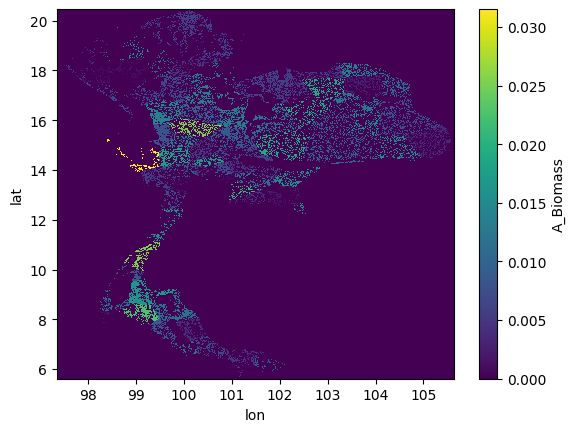

In [8]:
print(xr_final_SI['A_Biomass'].sum())
xr_final_SI['A_Biomass'].plot()

<xarray.DataArray 'test' ()>
array(34.54218415)
<xarray.DataArray 'test' ()>
array(0.00655819)
<xarray.DataArray 'test' ()>
array(8.38517759)


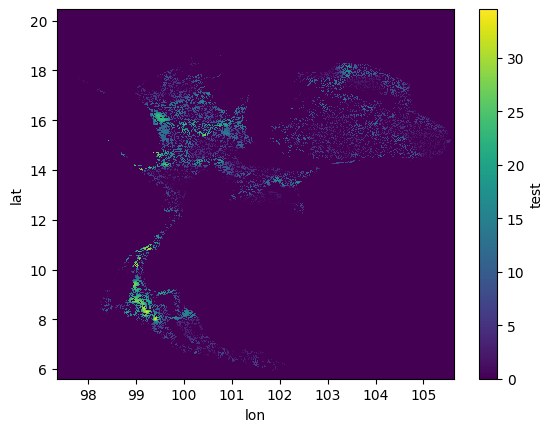

In [9]:
xr_final_SI['test'] = xr_final_SI['A_Biomass'].rolling(lon = rolgridsuitablearea_biomass, lat = rolgridsuitablearea_biomass, min_periods=1,center=True).sum()
xr_final_SI['test'] = xr.where( ((xr_final_SI['SI_Biomass'] == 0) ),0,xr_final_SI['test'])
xr_final_SI['test'].plot()
print(xr_final_SI['test'].where(xr_final_SI['test']>0).max())
print(xr_final_SI['test'].where(xr_final_SI['test']>0).min())
print(xr_final_SI['test'].where(xr_final_SI['test']>0).mean())


(103.09676066900005, 16.181673239000077, 104.24064016800008, 17.101957866000078)
<xarray.Dataset>
Dimensions:      (lat: 332, lon: 412)
Coordinates:
  * lat          (lat) float64 16.18 16.18 16.19 16.19 ... 17.09 17.1 17.1 17.1
  * lon          (lon) float64 103.1 103.1 103.1 103.1 ... 104.2 104.2 104.2
Data variables: (12/22)
    lccs_class   (lat, lon) int64 ...
    SI_BGEC      (lat, lon) float64 ...
    SI_Biomass   (lat, lon) float64 ...
    SI_Solar     (lat, lon) float64 ...
    SI_Wind      (lat, lon) float64 ...
    SI_BGWW      (lat, lon) float64 ...
    ...           ...
    AVA_Biomass  (lat, lon) float64 ...
    AVA_BGEC     (lat, lon) float64 ...
    AVA_BGWW     (lat, lon) float64 ...
    AVA_MSW      (lat, lon) float64 ...
    AVA_IEW      (lat, lon) float64 ...
    test         (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0


C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


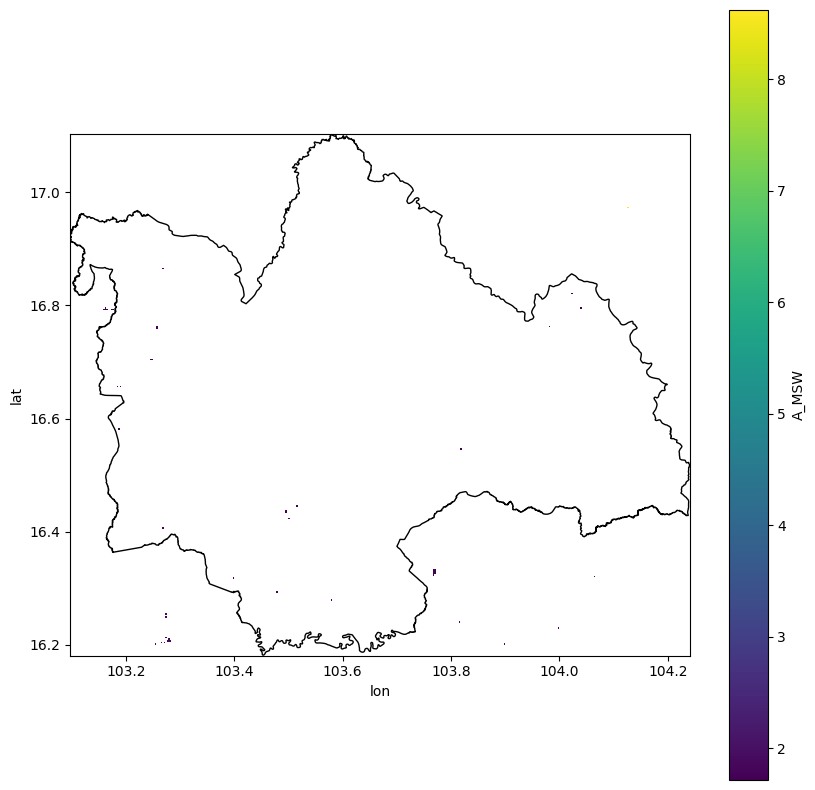

In [28]:
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}

province = "Kalasin"
province = thailandmap.loc[thailandmap['ADM1_EN'] == province]
print(province.unary_union.bounds)
min_lon = province.unary_union.bounds[0]
max_lon = province.unary_union.bounds[2]
max_lat = province.unary_union.bounds[3]
min_lat = province.unary_union.bounds[1]

xr_buffer = xr_final_SI.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
print(xr_buffer)

fig, ax = plt.subplots(figsize=(10,10))
province.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)

fueltype = 'A_MSW'
xr_buffer[fueltype].where(xr_buffer[fueltype]>0).plot(ax = ax,zorder = 1)

#############################################################################################################################